Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Maciej Wilhelmi"

---

# 2. Model konwolucyjny (CNN)
Następnie sprawdzimy architekturę autokodera opartego na warstwach konwolucyjnych (CNN).

## 2.1. Architektura
Zapoznaj się z poniższymi implementacjami kodera i dekodera.

In [8]:
from IPython.display import Code


Code(filename="src/cnn.py")

import torch
from torch import nn

from .ae import Autoencoder

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)


class CNNEncoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = nn.Sequential(
            # Convolution
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            # Invariant pooling
            nn.MaxPool2d(kernel_size=3),
            # Flattening
            nn.Flatten(),
            # MLP
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim),
        )

    def forward(self, img):
        return self._layers(img)


class CNNDecoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = nn.Sequential(
            # MLP
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            # Reshape into image
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # Deconvolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self._layers(z)


class CNNAutoencoder(Autoencoder):

    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=CNNEncoder(latent_dim=latent_dim),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )

## 2.2. Uczenie modelu
Podobnie jak w przypadku poprzedniego przykładu, model został nauczony i załączony w repozytorium.

In [9]:
LOG_PATH = "./data/CNN/logs"
CHECKPOINT_PATH = "./data/CNN/model.chkpt"

In [10]:
%load_ext tensorboard
%tensorboard --logdir $LOG_PATH --host 0.0.0.0 --port 6007

In [11]:
from src.dataset import SampledMNISTData
from src.cnn import CNNAutoencoder

Zakomentowany kod do uczenia modelu

W przypadku chęci modyfikacji, proszę odkomentować kod, przeuczyć model i zapisać go za pomocą metody `save_checkpoint`.

In [12]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# from src.dataset import SampledMNISTData

# conv_ae = CNNAutoencoder(latent_dim=2)
# trainer = Trainer(
#     max_epochs=10, 
#     logger=TensorBoardLogger(save_dir=LOG_PATH, name="conv_ae", default_hp_metric=False),
#     checkpoint_callback=False,
# )
# mnist = SampledMNISTData(num_samples_per_class=-1)

# trainer.fit(
#     model=conv_ae,
#     train_dataloaders=mnist,
# )

# trainer.save_checkpoint(filepath=CHECKPOINT_PATH)

Wczytujemy przeuczony model:

In [13]:
cnn_ae = CNNAutoencoder.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    latent_dim=2,
)

## 2.3. Badanie jakości reprezentacji w zadaniu

Wczytujemy losową próbkę zbioru danych MNIST:

In [14]:
mnist = SampledMNISTData(num_samples_per_class=100, seed=42)

Dla każdej próbki wyciągamy jej reprezentację (wektor dwu-wymiarowy) oraz etykietę:

In [15]:
from src.utils import extract_representations


representations = extract_representations(
    model=cnn_ae,
    dataset=mnist,
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
from src.utils import evaluate_linear    


auc_train, auc_test = evaluate_linear(
    z_train=representations["train"]["z"],
    y_train=representations["train"]["y"],
    z_test=representations["test"]["z"],
    y_test=representations["test"]["y"],
)

print(f"AUC => train: {auc_train * 100.0:.2f} [%], test: {auc_test * 100.0:.2f} [%]")

AUC => train: 91.08 [%], test: 91.18 [%]


## 2.4. Wizualizacja przestrzeni reprezentacji

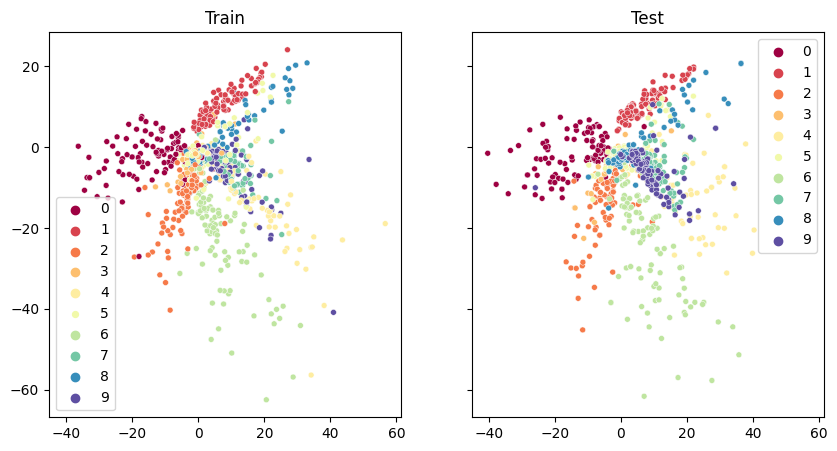

In [17]:
%matplotlib inline

from src.utils import visualize_latent_spaces


visualize_latent_spaces(representations)

## 2.5. Wizualizacja jakości rekonstrukcji

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


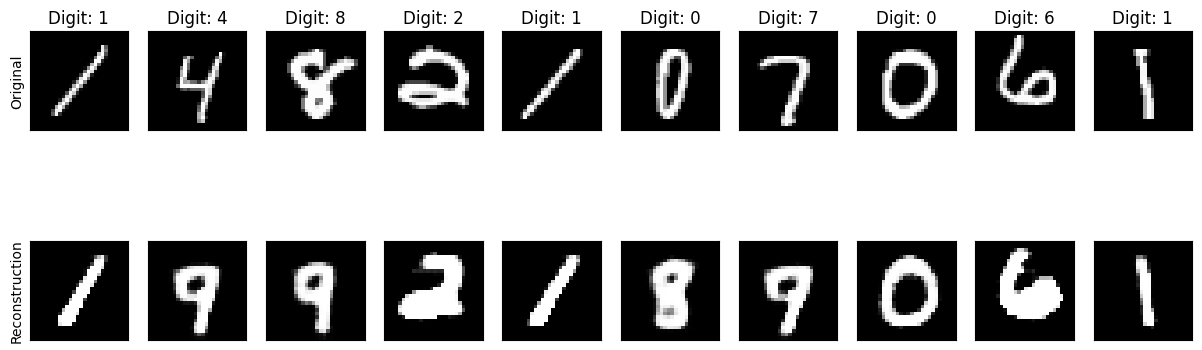

In [18]:
%matplotlib inline

from src.utils import visualize_random_sample

    
visualize_random_sample(model=cnn_ae, dataset=mnist.mnist_train)

## 2.6. Odporność modelu na przesunięcia

## Zadanie 2.1. (0 pkt)
Skopiuj implemetację funkcji `shift` z poprzedniego zeszytu do poniższej komórki.

In [19]:
import torch


def shift(img: torch.Tensor, dx: int, dy: int) -> torch.Tensor:
    # TU WPISZ KOD
    img_transformed = torch.roll(img, shifts=(dx, dy), dims=(1, 0))
    
    return img_transformed

Wybieramy dowolną instancję ze zbioru danych:

In [20]:
img, _ = mnist.mnist_train[100]

Zbadanie odporności na **przesunięcia poziome**:

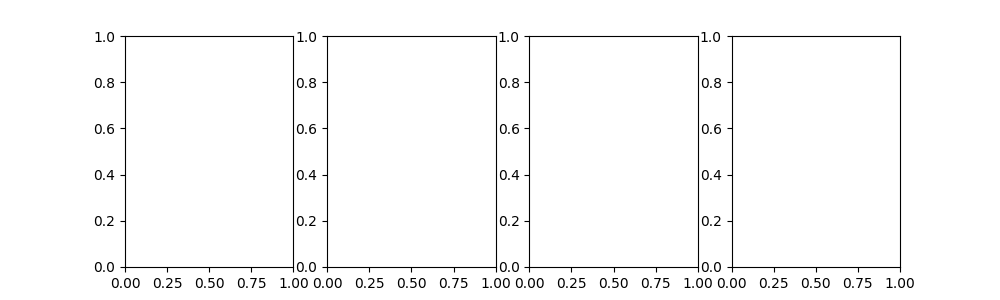

In [21]:
%matplotlib widget

from src.transforms import plot_transformation


def shift_horizontally(image: torch.Tensor, dx: int) -> torch.Tensor:
    return shift(img=image, dx=dx, dy=0)

    
plot_transformation(
    image=img,
    model=cnn_ae,
    transformation_fn=shift_horizontally,
    keep_channel_dim=True,  # Potrzebne do działania warstw kowolucyjnych
)

Zbadanie odporności na **przesunięcia pionowe**:

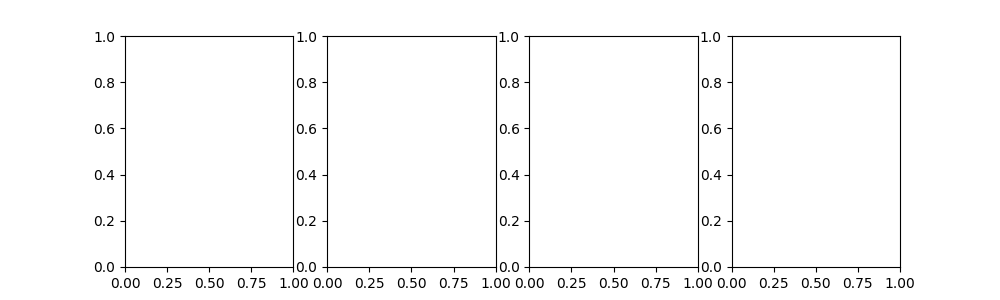

In [22]:
def shift_vertically(image: torch.Tensor, dy: int) -> torch.Tensor:
    return shift(img=image, dx=0, dy=dy)


plot_transformation(
    image=img,
    model=cnn_ae,
    transformation_fn=shift_vertically,
    keep_channel_dim=True, # Potrzebne do działania warstw kowolucyjnych
)

**Obserwacja**: Widzimy, że dla małych wartości przesunięć model działa poprawnie (tzn. rekonstrukcja nadal przypomina tę samą cyfrę). Przy większych przesunięciach rekonstrukcja jest zaburzona, jednak przetransformowana cyfra jest również zbyt zaburzona przez przesunięcie.

## 2.7. Odporność na obroty
Inną ważną grupą symetrii w przypadku przetwarzania obrazów jest **grupa obrotów**, np. grupa P4 opisująca obroty obiektów o 90 stopni.

Zbadamy teraz jak się zachowuje model oparty o sieci konwolucyjne w przypadku obrotów.

## Zadanie 2.2. (2 pkt)
Zaimplementuj funkcję `rotate`, która obróci obraz wejściowy `img` o `angle` stopni w lewo względem środka obrazu. Funkcja powinna obsługiwać ujemne wartości parametru obrotu, tzn. `angle < 0` (obrót w prawo).

In [23]:
import torch
import torchvision.transforms.functional as F

def rotate(img: torch.Tensor, angle: float) -> torch.Tensor:
    # TU WPISZ KOD
    img = img.unsqueeze(0)
    
    img_transformed = F.rotate(img, angle)
    
    img_transformed = img_transformed.squeeze(0)
    
    return img_transformed

In [45]:
# import matplotlib.pyplot as plt
# img=rotate(img, 100)

# plt.imshow(img[0], cmap="gray")
# plt.show()

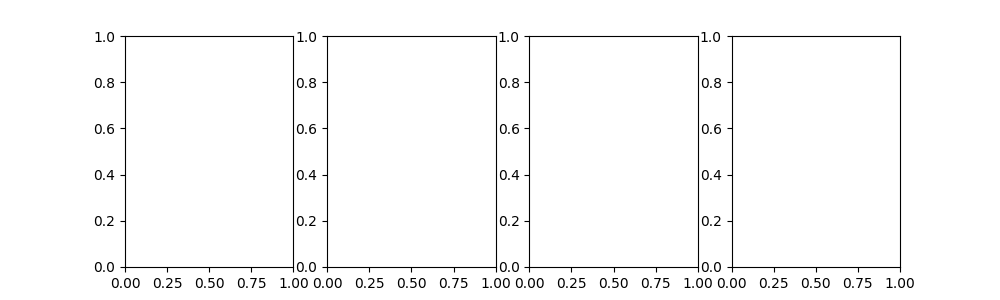

In [24]:
from src.transforms import plot_transformation


plot_transformation(
    image=img,
    model=cnn_ae,
    transformation_fn=rotate,
    min_param_value=0,
    max_param_value=360,
    step=10,
    keep_channel_dim=True,
)

## Zadanie 2.3 (0.5 pkt)
Czy autokoder CNN jest odporny na obroty obiektów? Z czego może to wynikać?

Nie jest odporny, może to być wynikiem tego, że w CNNach brakuje odpowiedniej inwariantności przestrzeni. Czyli sieci uczą się cech obrazu, ale kiedy zostaną one odwrócone, to wyuczone cechy na nic się nie zdają.